This algo is a bit different from the first algo we made.  Instead of hahazardly defining a function to always
purchase chares every day, we'll instead tell the algo under what conditions we want to think about purchasing
shares.  This will help a lot in terms of performance and should help us transition into more complex algos.  We 
also start to think about how long we're holding shares, because in the first algo we never sold our assets.

It's important to note that in zipline even if we purchase shares based on some boolean or numerical comparison, 
it doesn't automatically sell the asset once the condition fails.  Instead we have to make sure that we order 0 shares
to sell the stock once our given condition fails.  

We also implement other important features such as leverage control and keeping track of our open positions, so we don't keep purchasing more of an asset if we already made an order.  

When you analyze the tear sheet, think about how much more stable our algorithm generally seems.  We have single digit drawdown and make some decent profit.  However this approach is dangerous because we don't diversify by also short selling and we only purchase a fixed amount of asset each time.  

In [5]:
from zipline.api import symbol, order_target, set_max_leverage
from zipline import run_algorithm
import warnings
import pyfolio as pf
import pandas as pd
warnings.filterwarnings("ignore")


# in this algo we take a filter based apporach to deciding what stocks to purchase.  In essense we define a boolean 
# functions purchase_share to pick our orders.  In zipline filters are usually booleans like is_tradable, whereas
# factors are number values like technical indicators or fundamental business data.

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
MAX_BAR_HOLD = 3 # only hold a stock for max 3 bars (days in our case)



def initialize(algo):
    algo.stocks = STOCKS
    algo.symbol_ids = [algo.symbol(asset) for asset in STOCKS]
    algo.set_max_leverage(1.0) # only allowed to invest 100% of our total portfolio value
    algo.has_open_positions = {symbol: False for symbol in algo.symbol_ids} 
    algo.bars_held = {symbol: 0 for symbol in algo.symbol_ids} # number of bars (ie timesteps) we've held an asset

def purchase_share(algo, data):
    recent = data.history(assets=algo.symbol_ids, fields='close', bar_count=60, frequency='1d')
    short_mean = recent[-10:].mean()
    long_mean = recent[-50:].mean()
    return (short_mean > long_mean) # short term is outperforming long term
    

def handle_data(algo, data):
    purchase = purchase_share(algo, data)
    for security in algo.symbol_ids:
        if not algo.has_open_positions[security] and purchase[security]:
            order_target(security, target=2) 
            
            # set positions tracker values 
            algo.has_open_positions[security] = True;
            algo.bars_held[security] += 1;
        elif algo.bars_held[security] > MAX_BAR_HOLD or not purchase[security]:  # long mean crosses over short mean
            order_target(security, target=0) # order 0 (sell share)
            
            # reset value for security's open positions
            algo.has_open_positions[security] = False
            algo.bars_held[security] = 0
            


start = pd.Timestamp('2015-1-1', tz='utc')
end = pd.Timestamp('2018-1-1', tz='utc')
results = run_algorithm(start=start, end=end, capital_base=1000, initialize=initialize, handle_data=handle_data)

returns, positions, orders = pf.utils.extract_rets_pos_txn_from_zipline(results)

Start date,2015-01-02
End date,2017-12-29
Total months,35
,Backtest
Annual return,7.2%
Cumulative returns,23.2%
Annual volatility,7.6%
Sharpe ratio,0.96
Calmar ratio,1.15
Stability,0.73
Max drawdown,-6.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.27,2015-11-02,2016-02-11,2016-07-08,180
1,6.19,2015-03-23,2015-08-25,2015-10-27,157
2,5.64,2017-06-14,2017-08-21,2017-10-24,95
3,4.88,2016-08-15,2016-11-30,2017-02-09,129
4,3.89,2017-05-04,2017-05-17,2017-06-01,21


Stress Events,mean,min,max
Fall2015,-0.04%,-1.23%,1.13%
New Normal,0.03%,-1.91%,2.29%


Top 10 long positions of all time,max
sid,
MMM,40.16%
COST,32.60%
CERN,14.71%
GPS,8.63%
INTC,8.03%
AMD,2.74%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
MMM,40.16%
COST,32.60%
CERN,14.71%
GPS,8.63%
INTC,8.03%
AMD,2.74%


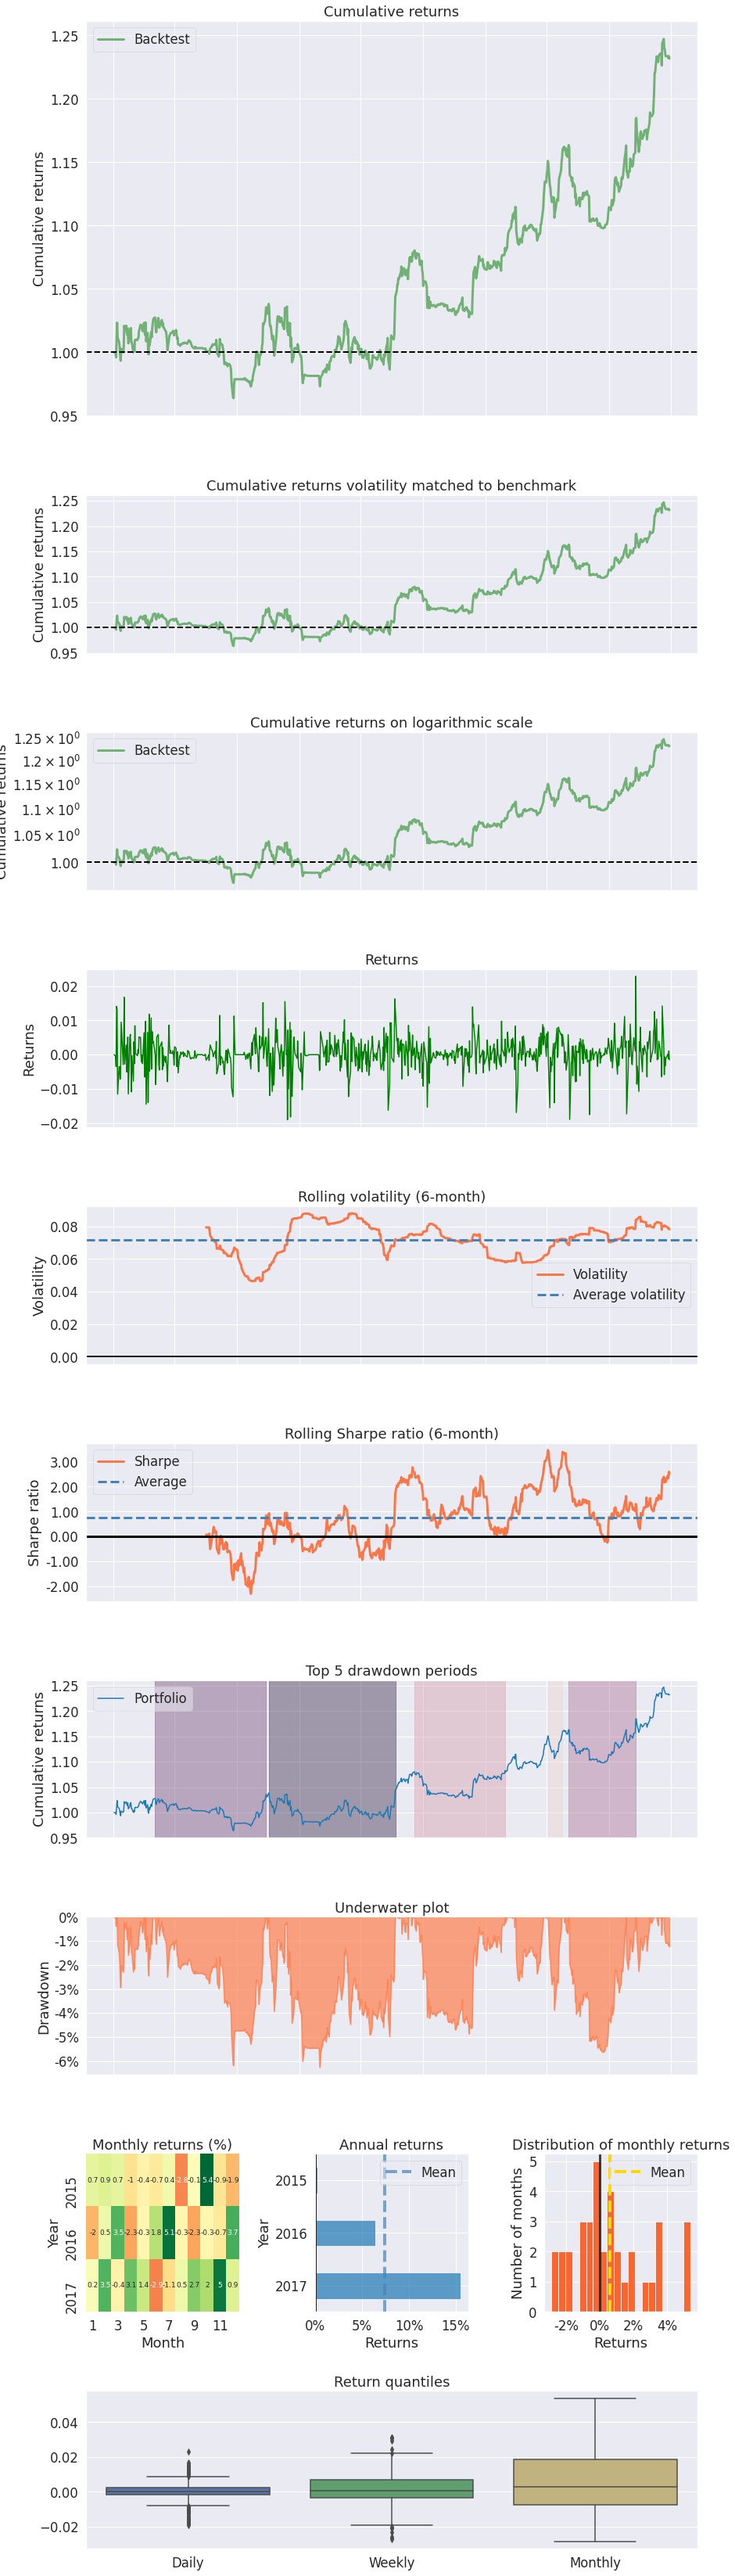

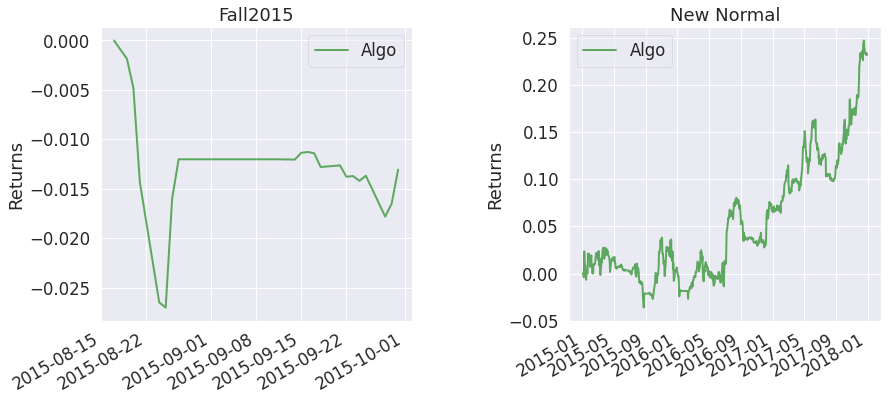

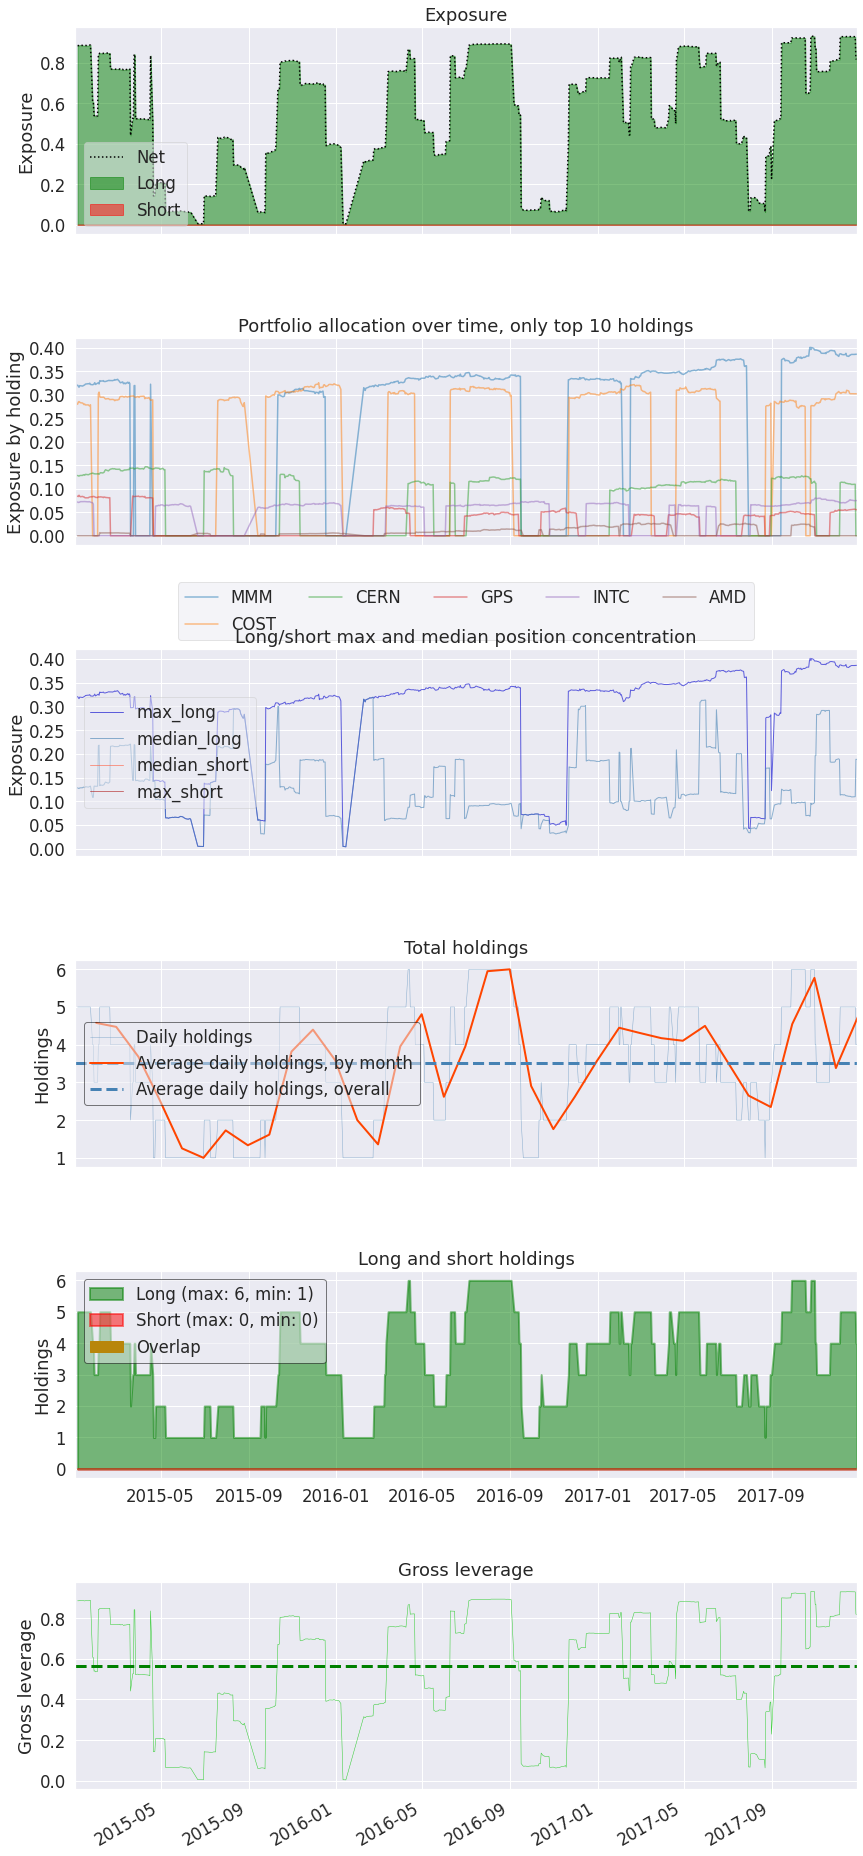

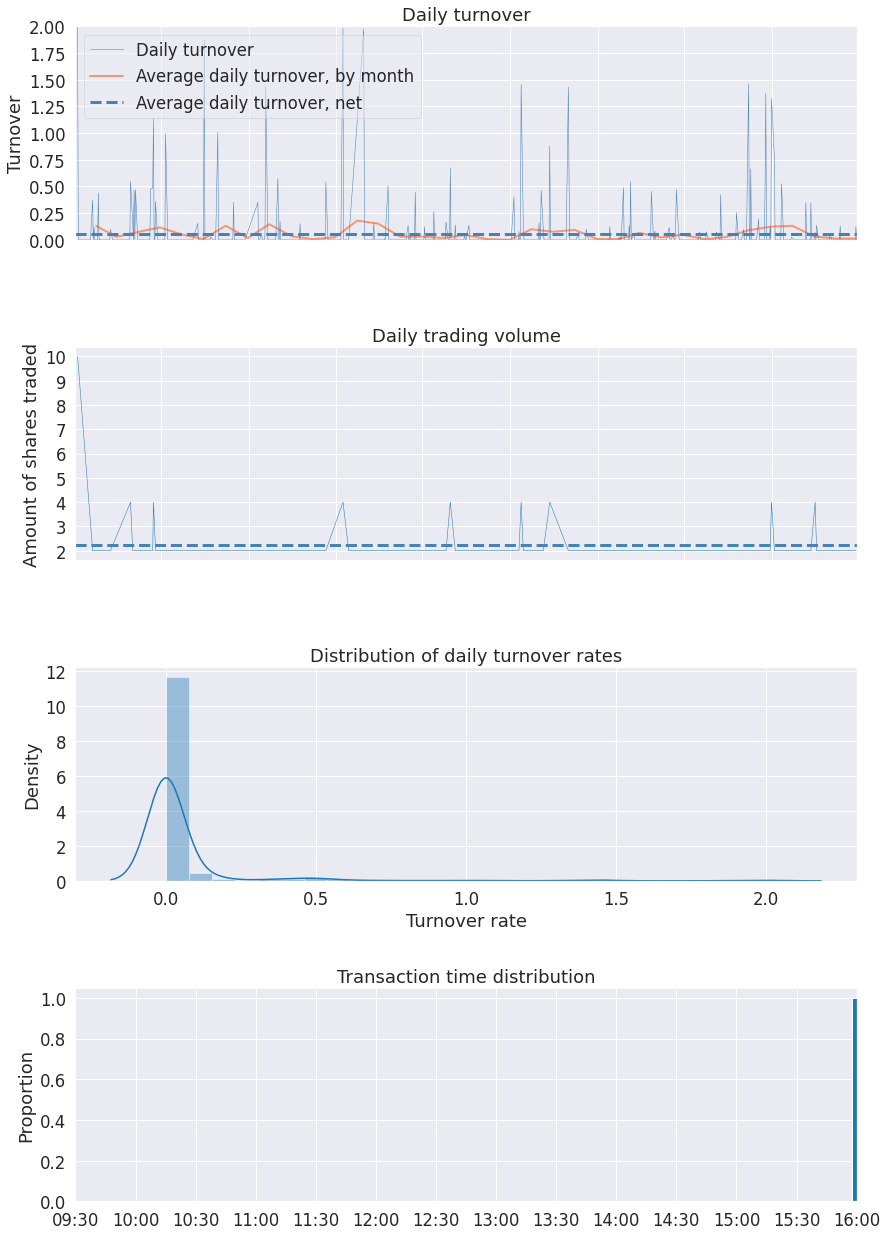

In [6]:
pf.create_full_tear_sheet(returns=returns, positions=positions, transactions=orders)